In [0]:
import pandas as pd
import random
import numpy as np
import keras
from keras.layers import *
from keras import backend as k
from keras import optimizers
from keras.models import Model
from time import time
from keras.models import load_model
from google.colab import files

In [6]:
uploaded = files.upload()

Saving mfccs2.npy to mfccs2.npy
Saving mfccs3.npy to mfccs3.npy
Saving pitches2.npy to pitches2.npy
Saving pitches3.npy to pitches3.npy


In [0]:
mfccs1 = np.load('mfccs1.npy')
mfccs2 = np.load('mfccs2.npy')
mfccs3 = np.load('mfccs3.npy')
#mfccs4 = np.load('mfccs4.npy')

In [0]:
pitches1 = np.load('pitches1 (1).npy')
pitches2 = np.load('pitches2.npy')
pitches3 = np.load('pitches3.npy')
#pitches4 = np.load('pitches4.npy')

In [4]:
mfccs2.shape

(2004, 1500, 12)

In [0]:
mfccs = np.append(mfccs1, mfccs2, axis = 0)
#mfccs34 = np.append(mfccs3, mfccs4, axis = 0)
#mfccs = np.append(mfccs12, mfccs34, axis = 0)

pitches = np.append(pitches1, pitches2, axis = 0)
#pitches34 = np.append(pitches3, pitches4, axis = 0)
#pitches = np.append(pitches12, pitches34, axis = 0)

In [0]:
loudness_ = np.load('loudness.npy')

In [0]:
loudness = loudness_[:4008]

In [18]:
loudness.shape

(4008, 1500, 1)

In [0]:
features = np.append(mfccs, pitches, axis = 2)
features_ = np.append(features, loudness, axis = 2)

In [13]:
features_.shape

(4008, 1500, 25)

In [0]:
loudness_val = loudness_[4008:4408]

In [10]:
loudness_val.shape

(400, 1500, 1)

In [0]:
val_features = np.append(mfccs3[:400], pitches3[:400], axis = 2)
val_data = np.append(val_features, loudness_val, axis = 2)

In [12]:
val_data.shape

(400, 1500, 25)

In [0]:
features_dim = 1500
wide = 25
BATCH_SIZE  = 64
N1 = 32
N2 = 32
Nfc = 520
L1 = 30
L2 = 15

In [0]:
batches = int(len(features_)/BATCH_SIZE)

In [0]:
def batch_generator():
    
  while True:
    
    for batch in range(batches):
      x_ = []
      
      data_ = features_[batch * BATCH_SIZE: (batch + 1) * BATCH_SIZE]
      for i in data_:
          x_.append(np.reshape(i, (features_dim, wide)))

      x = np.asarray(x_)
      
      yield (x, x)

In [0]:
#autoencoder = load_model('model1.h5')

In [0]:
#ENCODER

input1 = Input(shape = (features_dim, wide))

encoder = Conv1D(N1, L1, strides = 1, padding = 'SAME', use_bias = True, 
                 bias_initializer = keras.initializers.Constant(value=0.1), activation = 'relu')(input1)

encoder = MaxPooling1D(pool_size = 2, strides = 2)(encoder)

encoder = Conv1D(N2, L2, strides = 1, padding = 'SAME', use_bias = True, 
                 bias_initializer = keras.initializers.Constant(value=0.1), activation = 'relu')(encoder)

encoder = MaxPooling1D(pool_size = 2, strides = 2)(encoder)

out_shape = list(k.int_shape(encoder))

encoder = Flatten()(encoder)

encoder = Dense(Nfc, activation = 'relu')(encoder)

encoder = Dropout(0.7)(encoder)

encoder = Dense(20, activation = 'sigmoid')(encoder)


#DECODER

decoder = Dense((out_shape[1] * out_shape[2]), activation = 'relu')(encoder)

decoder = Dropout(0.7)(decoder)

decoder = Reshape((out_shape[1], out_shape[2]))(decoder)

decoder = UpSampling1D(size = 2)(decoder)

decoder = Conv1D(N2, L2, strides = 1, padding = 'SAME', use_bias = True, 
                 bias_initializer = keras.initializers.Constant(value=0.1), activation = 'relu')(decoder)

decoder = UpSampling1D(size = 2)(decoder)

decoder = Conv1D(N1, L1, strides = 1, padding = 'SAME', use_bias = True, 
                 bias_initializer = keras.initializers.Constant(value=0.1), activation = 'relu')(decoder)

out = Conv1D(wide, 1, padding = 'same', activation = 'sigmoid')(decoder)


autoencoder = Model(input1, out)

In [18]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1500, 25)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1500, 32)          24032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 750, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 750, 32)           15392     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 375, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 520)               6240520   
__________

In [0]:
encoder_ = Model(input1, encoder)

In [20]:
encoder_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1500, 25)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1500, 32)          24032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 750, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 750, 32)           15392     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 375, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 520)               6240520   
__________

In [0]:
adam_ = optimizers.Adam(lr = 1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [0]:
autoencoder.compile(loss = 'binary_crossentropy', optimizer = adam_)

In [23]:
history = autoencoder.fit_generator(batch_generator(), steps_per_epoch = batches, validation_data = (val_data, val_data), epochs = 10, shuffle = True)

Epoch 1/10
62/62 [==============================] - 148s 2s/step - loss: -3.2463 - val_loss: -13.7281
Epoch 2/10
62/62 [==============================] - 141s 2s/step - loss: -36.0068 - val_loss: -50.4367
Epoch 3/10
62/62 [==============================] - 137s 2s/step - loss: -51.8322 - val_loss: -53.1623
Epoch 4/10
62/62 [==============================] - 127s 2s/step - loss: -55.1531 - val_loss: -57.2332
Epoch 5/10
62/62 [==============================] - 124s 2s/step - loss: -59.8591 - val_loss: -61.9494
Epoch 6/10
62/62 [==============================] - 124s 2s/step - loss: -62.4754 - val_loss: -63.2647
Epoch 7/10
62/62 [==============================] - 127s 2s/step - loss: -64.0533 - val_loss: -64.9057
Epoch 8/10
62/62 [==============================] - 126s 2s/step - loss: -65.2356 - val_loss: -65.1422
Epoch 9/10
62/62 [==============================] - 128s 2s/step - loss: -65.8326 - val_loss: -66.1421
Epoch 10/10
62/62 [==============================] - 127s 2s/step - loss: 

In [0]:
autoencoder.save('model1.h5')

In [0]:
encoder_.save('encoder1.h5')

In [0]:
files.download('model1.h5')

In [0]:
files.download('encoder1.h5')

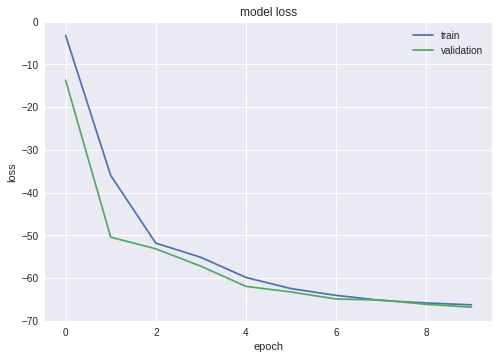

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [7]:
encoder_ = load_model('encoder1.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
val_pred = encoder_.predict(val_data, batch_size = 32)

In [32]:
val_pred.shape

(400, 20)